# Building the recommendation algo with Contextual Multi-Arm bandits (MAB)

Contextual bandits take into account extra infromation about the user, such as age, gender, occupatioin etc. All this are factered in before when selcting a movie. This is much more closer to real world reccomendation systems than the vanilla Multi-Arm Bandit algo that offers a blankes sollution for all the users

In a contextual bandit:

The fillowing is considered at each time step:

- The agent observes context (features of the user, item, or both).
- It selects an arm (movie, genre, tag, etc.).
- It receives a reward (rating, click, etc.).

The goal is to learn a policy that maps context → action (arm) to maximize cumulative reward.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import time
import logging
from tqdm import tqdm
from collections import defaultdict
import warnings


In [2]:
warnings.filterwarnings('ignore')
# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

### Load and Merge Data

In [3]:
# Load ratings, user info, and movie info
ratings = pd.read_csv("../data/ml-100k/u.data", sep='\t', names=["user_id", "item_id", "rating", "timestamp"])
users = pd.read_csv("../data/ml-100k/u.user", sep='|', names=["user_id", "age", "gender", "occupation", "zip_code"])
items = pd.read_csv("../data/ml-100k/u.item", sep='|', encoding="latin-1", header=None)

# Select relevant item columns
genre_columns = ['unknown', 'Action', 'Adventure', 'Animation', "Children's", 'Comedy', 'Crime',
                 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical',
                 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
items.columns = ['item_id', 'title', 'release_date', 'video_release_date', 'IMDb_URL'] + genre_columns

# Merge
df = ratings.merge(users, on='user_id').merge(items, on='item_id')


In [4]:
df.head()

,user_id,item_id,rating,timestamp,age,gender,occupation,zip_code,title,release_date,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,196,242,3,881250949,49,M,writer,55105,Kolya (1996),24-Jan-1997,...,0,0,0,0,0,0,0,0,0,0
1,186,302,3,891717742,39,F,executive,00000,L.A. Confidential (1997),01-Jan-1997,...,0,1,0,0,1,0,0,1,0,0
2,22,377,1,878887116,25,M,writer,40206,Heavyweights (1994),01-Jan-1994,...,0,0,0,0,0,0,0,0,0,0
3,244,51,2,880606923,28,M,technician,80525,Legends of the Fall (1994),01-Jan-1994,...,0,0,0,0,0,1,0,0,1,1
4,166,346,1,886397596,47,M,educator,55113,Jackie Brown (1997),01-Jan-1997,...,0,0,0,0,0,0,0,0,0,0


### Encode Features (Context)

In [5]:
#One hot encode gender


# One-hot encode gender and occupation
df['gender'] = df['gender'].map({'M': 0, 'F': 1})

In [6]:
df.head()

,user_id,item_id,rating,timestamp,age,gender,occupation,zip_code,title,release_date,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,196,242,3,881250949,49,0,writer,55105,Kolya (1996),24-Jan-1997,...,0,0,0,0,0,0,0,0,0,0
1,186,302,3,891717742,39,1,executive,00000,L.A. Confidential (1997),01-Jan-1997,...,0,1,0,0,1,0,0,1,0,0
2,22,377,1,878887116,25,0,writer,40206,Heavyweights (1994),01-Jan-1994,...,0,0,0,0,0,0,0,0,0,0
3,244,51,2,880606923,28,0,technician,80525,Legends of the Fall (1994),01-Jan-1994,...,0,0,0,0,0,1,0,0,1,1
4,166,346,1,886397596,47,0,educator,55113,Jackie Brown (1997),01-Jan-1997,...,0,0,0,0,0,0,0,0,0,0


In [7]:
from sklearn.preprocessing import OneHotEncoder

# One-hot encode occupation
occupation_enc = OneHotEncoder(sparse_output=False)
occupation_encoded = occupation_enc.fit_transform(df[['occupation']])
occupation_df = pd.DataFrame(occupation_encoded, columns=occupation_enc.get_feature_names_out(['occupation']))



In [8]:
occupation_df.head()

,occupation_administrator,occupation_artist,occupation_doctor,occupation_educator,occupation_engineer,occupation_entertainment,occupation_executive,occupation_healthcare,occupation_homemaker,occupation_lawyer,...,occupation_marketing,occupation_none,occupation_other,occupation_programmer,occupation_retired,occupation_salesman,occupation_scientist,occupation_student,occupation_technician,occupation_writer
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
#combine all context

context_features = pd.concat([
    df[['age', 'gender']],
    occupation_df,
    df[genre_columns]
], axis=1)

In [10]:
context_features.head()

,age,gender,occupation_administrator,occupation_artist,occupation_doctor,occupation_educator,occupation_engineer,occupation_entertainment,occupation_executive,occupation_healthcare,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,49,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,39,1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0,1,0,0,1,0,0,1,0,0
2,25,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,28,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,1,0,0,1,1
4,47,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


### Contextual Bandit Algorithm

For simplicity we will be using the LinUCB, any funtional approximater alo would work including an neural net, 


ucb explained:

![ucb.png](../images/ucb.png)


In [11]:
class LinUCB:
    def __init__(self, n_arms, context_dim, alpha=1.0):
        self.alpha = alpha
        self.n_arms = n_arms
        self.A = [np.identity(context_dim) for _ in range(n_arms)]
        self.b = [np.zeros((context_dim,)) for _ in range(n_arms)]

    def select_arm(self, x):
        x = x.reshape(-1, 1)
        p = []
        for arm in range(self.n_arms):
            A_inv = np.linalg.inv(self.A[arm])
            theta = A_inv @ self.b[arm]
            p_val = theta.T @ x + self.alpha * np.sqrt(x.T @ A_inv @ x)
            p.append(p_val)
        return int(np.argmax(p))

    def update(self, arm, x, reward):
        x = x.reshape(-1, 1)
        self.A[arm] += x @ x.T
        self.b[arm] += reward * x.flatten()


In [12]:
class EnhancedLinUCB(LinUCB):
    def __init__(self, n_arms, context_dim, alpha=1.0):
        super().__init__(n_arms, context_dim, alpha)
        self.arm_counts = defaultdict(int)
        self.arm_rewards = defaultdict(list)
        self.total_reward = 0
        self.step_count = 0
        self.regret_history = []
        self.reward_history = []
        self.exploration_history = []
        
    def select_arm(self, x):
        self.step_count += 1
        x = x.reshape(-1, 1)
        p = []
        
        for arm in range(self.n_arms):
            A_inv = np.linalg.inv(self.A[arm])
            theta = A_inv @ self.b[arm]
            p_val = theta.T @ x + self.alpha * np.sqrt(x.T @ A_inv @ x)
            p.append(p_val)
        
        chosen_arm = int(np.argmax(p))
        self.arm_counts[chosen_arm] += 1
        
        # Track exploration vs exploitation
        exploration_score = self.alpha * np.sqrt(x.T @ np.linalg.inv(self.A[chosen_arm]) @ x)
        exploitation_score = (np.linalg.inv(self.A[chosen_arm]) @ self.b[chosen_arm]).T @ x
        self.exploration_history.append(exploration_score[0, 0])
        
        return chosen_arm
    
    def update(self, arm, x, reward):
        super().update(arm, x, reward)
        self.arm_rewards[arm].append(reward)
        self.total_reward += reward
        self.reward_history.append(reward)
        
        # Calculate regret (assuming optimal reward is 1.0)
        optimal_reward = 1.0
        regret = optimal_reward - reward
        self.regret_history.append(regret)

### Train the Bandit Agent


In [13]:
num_movies = df['item_id'].nunique()



In [14]:
num_movies


1682

In [ ]:
# linucb = LinUCB(n_arms=num_movies, context_dim=context_features.shape[1])

# for i in range(len(df)):
#     user_context = context_features.iloc[i].values
#     movie_id = df.iloc[i]['item_id']
#     reward = df.iloc[i]['rating'] / 5.0  # Normalize to [0, 1]

#     chosen_arm = linucb.select_arm(user_context)
#     if chosen_arm == movie_id:
#         linucb.update(chosen_arm, user_context, reward)


KeyboardInterrupt: 

In [16]:
def train_with_logging(df, context_features, num_epochs=1, log_interval=1000):
    """
    Enhanced training function with comprehensive logging and visualization
    """
    num_movies = df['item_id'].nunique()
    logger.info(f"Starting training with {num_movies} movies and {len(df)} interactions")
    
    # Initialize the enhanced bandit
    bandit = EnhancedLinUCB(n_arms=num_movies, context_dim=context_features.shape[1])
    
    # Training metrics
    total_interactions = len(df) * num_epochs
    cumulative_rewards = []
    cumulative_regrets = []
    accuracy_history = []
    
    logger.info(f"Training for {num_epochs} epochs ({total_interactions} total interactions)")
    
    # Progress bar
    pbar = tqdm(total=total_interactions, desc="Training Progress")
    
    start_time = time.time()
    
    for epoch in range(num_epochs):
        epoch_rewards = []
        epoch_correct_predictions = 0
        
        for i in range(len(df)):
            user_context = context_features.iloc[i].values
            movie_id = df.iloc[i]['item_id'] - 1  # Adjust for 0-based indexing
            reward = df.iloc[i]['rating'] / 5.0  # Normalize to [0, 1]
            
            chosen_arm = bandit.select_arm(user_context)
            
            # Update if prediction matches actual movie
            if chosen_arm == movie_id:
                bandit.update(chosen_arm, user_context, reward)
                epoch_correct_predictions += 1
            
            epoch_rewards.append(reward)
            
            # Log progress
            if (epoch * len(df) + i + 1) % log_interval == 0:
                current_step = epoch * len(df) + i + 1
                avg_reward = np.mean(epoch_rewards[-log_interval:])
                accuracy = epoch_correct_predictions / log_interval
                exploration_ratio = np.mean(bandit.exploration_history[-log_interval:])
                
                logger.info(f"Step {current_step}: Avg Reward={avg_reward:.3f}, "
                          f"Accuracy={accuracy:.3f}, Exploration={exploration_ratio:.3f}")
                
                cumulative_rewards.append(bandit.total_reward)
                cumulative_regrets.append(np.sum(bandit.regret_history))
                accuracy_history.append(accuracy)
            
            pbar.update(1)
            pbar.set_postfix({
                'Epoch': epoch + 1,
                'Avg Reward': f"{np.mean(epoch_rewards):.3f}",
                'Accuracy': f"{epoch_correct_predictions/(i+1):.3f}"
            })
    
    pbar.close()
    training_time = time.time() - start_time
    
    logger.info(f"Training completed in {training_time:.2f} seconds")
    logger.info(f"Final total reward: {bandit.total_reward:.2f}")
    logger.info(f"Final average reward: {np.mean(bandit.reward_history):.3f}")
    
    return bandit, {
        'cumulative_rewards': cumulative_rewards,
        'cumulative_regrets': cumulative_regrets,
        'accuracy_history': accuracy_history,
        'training_time': training_time
    }

            

2025-08-05 10:39:58,800 - INFO - Starting enhanced UCB training...
2025-08-05 10:39:58,806 - INFO - Starting training with 1682 movies and 100000 interactions
2025-08-05 10:39:58,911 - INFO - Training for 1 epochs (100000 total interactions)
Training Progress: 100%|██████████| 100000/100000 [3:44:41<00:00,  7.42it/s, Epoch=1, Avg Reward=0.706, Accuracy=0.001]
2025-08-05 14:24:40,313 - INFO - Training completed in 13481.39 seconds
2025-08-05 14:24:40,359 - INFO - Final total reward: 54.80
2025-08-05 14:24:40,409 - INFO - Final average reward: 0.741


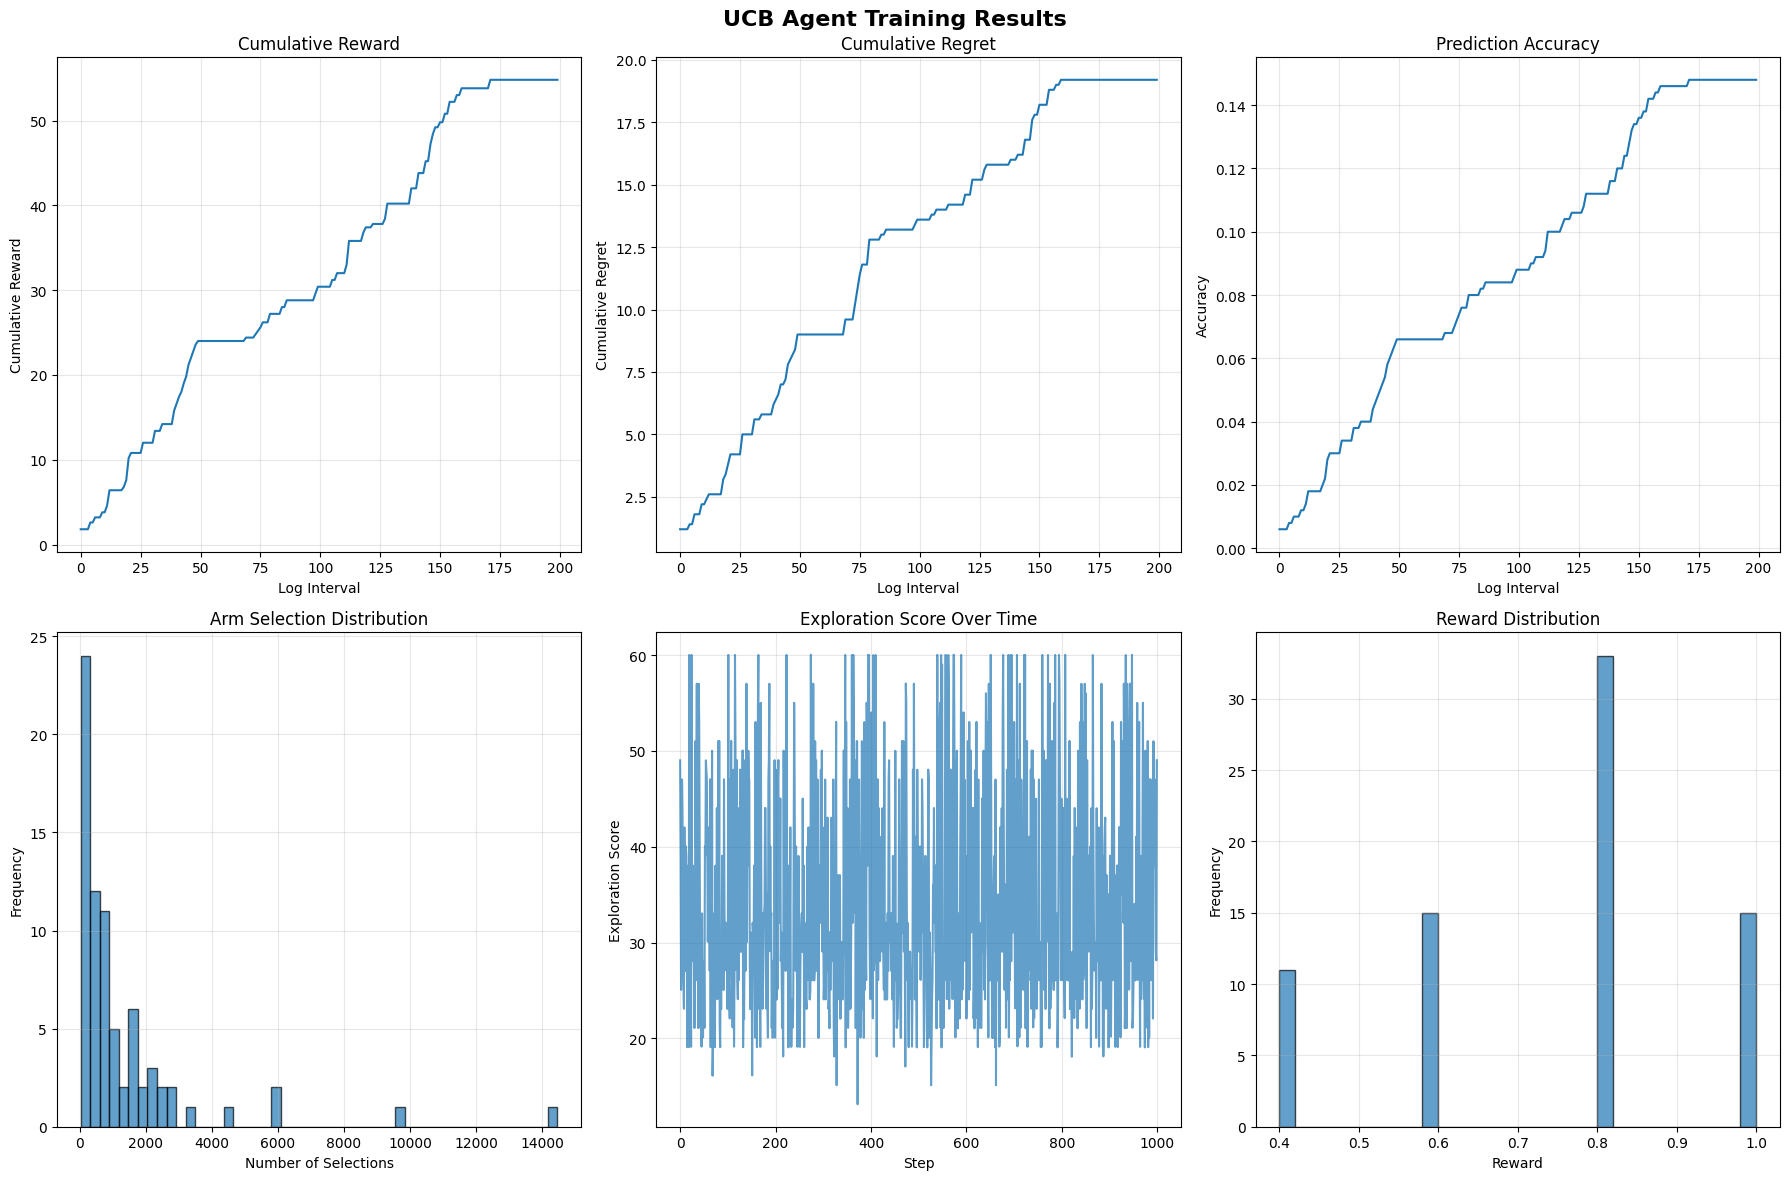


TRAINING SUMMARY
Total Training Time: 13481.39 seconds
Total Interactions: 100,000
Final Total Reward: 54.80
Average Reward: 0.741
Final Accuracy: 0.148
Most Selected Arm: 74
Least Selected Arm: 0


In [17]:
def visualize_training_results(bandit, metrics):
    """
    Create comprehensive visualizations of training results
    """
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('UCB Agent Training Results', fontsize=16, fontweight='bold')
    
    # 1. Cumulative Reward over Time
    axes[0, 0].plot(metrics['cumulative_rewards'])
    axes[0, 0].set_title('Cumulative Reward')
    axes[0, 0].set_xlabel('Log Interval')
    axes[0, 0].set_ylabel('Cumulative Reward')
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. Cumulative Regret over Time
    axes[0, 1].plot(metrics['cumulative_regrets'])
    axes[0, 1].set_title('Cumulative Regret')
    axes[0, 1].set_xlabel('Log Interval')
    axes[0, 1].set_ylabel('Cumulative Regret')
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. Accuracy over Time
    axes[0, 2].plot(metrics['accuracy_history'])
    axes[0, 2].set_title('Prediction Accuracy')
    axes[0, 2].set_xlabel('Log Interval')
    axes[0, 2].set_ylabel('Accuracy')
    axes[0, 2].grid(True, alpha=0.3)
    
    # 4. Arm Selection Distribution
    arm_counts = list(bandit.arm_counts.values())
    axes[1, 0].hist(arm_counts, bins=50, alpha=0.7, edgecolor='black')
    axes[1, 0].set_title('Arm Selection Distribution')
    axes[1, 0].set_xlabel('Number of Selections')
    axes[1, 0].set_ylabel('Frequency')
    axes[1, 0].grid(True, alpha=0.3)
    
    # 5. Exploration vs Exploitation
    exploration_ratio = np.array(bandit.exploration_history)
    axes[1, 1].plot(exploration_ratio[:1000], label='Exploration Score', alpha=0.7)
    axes[1, 1].set_title('Exploration Score Over Time')
    axes[1, 1].set_xlabel('Step')
    axes[1, 1].set_ylabel('Exploration Score')
    axes[1, 1].grid(True, alpha=0.3)
    
    # 6. Reward Distribution
    axes[1, 2].hist(bandit.reward_history, bins=30, alpha=0.7, edgecolor='black')
    axes[1, 2].set_title('Reward Distribution')
    axes[1, 2].set_xlabel('Reward')
    axes[1, 2].set_ylabel('Frequency')
    axes[1, 2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("\n" + "="*50)
    print("TRAINING SUMMARY")
    print("="*50)
    print(f"Total Training Time: {metrics['training_time']:.2f} seconds")
    print(f"Total Interactions: {bandit.step_count:,}")
    print(f"Final Total Reward: {bandit.total_reward:.2f}")
    print(f"Average Reward: {np.mean(bandit.reward_history):.3f}")
    print(f"Final Accuracy: {metrics['accuracy_history'][-1]:.3f}")
    print(f"Most Selected Arm: {max(bandit.arm_counts, key=bandit.arm_counts.get)}")
    print(f"Least Selected Arm: {min(bandit.arm_counts, key=bandit.arm_counts.get)}")
    print("="*50)
    
    
# Run the enhanced training
logger.info("Starting enhanced UCB training...")
bandit, metrics = train_with_logging(df, context_features, num_epochs=1, log_interval=500)

# Visualize results
visualize_training_results(bandit, metrics)
    
    